In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import tensorflow as tf
from keras.models import Model
from keras.models import Sequential

from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Add

from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Conv1D
from keras.layers import ConvLSTM2D
from keras.layers import MaxPooling1D

from keras.layers import Bidirectional
from keras.layers import TimeDistributed

from keras.utils import plot_model


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse


In [4]:
if not os.path.exists("figures"):
    os.makedirs("figures")
    os.makedirs("figures/model")
    os.makedirs("figures/chart")
    os.makedirs("figures/result")
    print("mkdir... ")

mkdir... 


In [5]:
plt.style.use('seaborn-v0_8-paper')
plt.xkcd()
plt.rcParams["font.family"] = "sans-serif"

In [6]:
path = "/content/drive/MyDrive/Colab Notebooks/Datasets/GOOG.csv"

In [7]:
# ! rm *.png *.csv *.zip
# ! rm -r figures

# load data

In [8]:
df = pd.read_csv(path, index_col="Date", parse_dates=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-11,62.485001,63.048000,59.803501,60.770500,60.770500,52170000
2020-03-12,56.299999,59.693501,55.665001,55.745499,55.745499,84534000
2020-03-13,58.950001,60.987999,55.857151,60.986500,60.986500,74002000
2020-03-16,54.799999,57.613350,53.722000,54.216499,54.216499,85048000
2020-03-17,54.655499,56.542999,52.800499,55.990002,55.990002,77230000
...,...,...,...,...,...,...
2022-09-06,108.135002,108.879997,106.510002,107.480003,107.480003,20565100
2022-09-07,107.760002,110.989998,107.614998,110.480003,110.480003,22987200
2022-09-08,109.180000,110.580002,108.059998,109.419998,109.419998,21660700


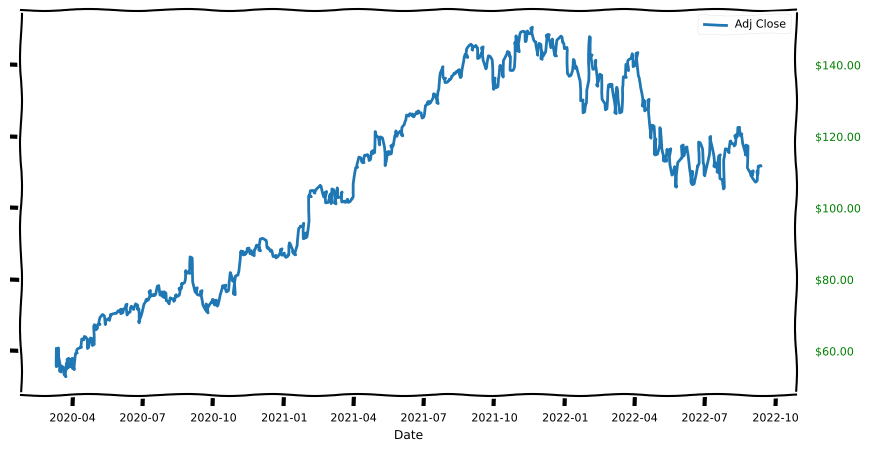

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(df["Adj Close"], label="Adj Close")
ax.set_xlabel("Date")
ax.yaxis.set_major_formatter('${x:1.2f}')

ax.yaxis.set_tick_params(which='major', labelcolor='green',
                         labelleft=False, labelright=True)
ax.legend()
plt.show()

# PreProcessing

In [10]:
def split_data_target(data, data_col,target_col):
    return data[data_col].values, data[target_col].values

In [11]:
data_col = ['Open', 'High', 'Low', 'Close',"Volume"]
target_col = ["Adj Close"]
data, target = split_data_target(df, data_col, target_col)


In [12]:
scaler_data = MinMaxScaler()
scaler_target = MinMaxScaler()

In [13]:
data_sc = scaler_data.fit(data)
target_sc = scaler_target.fit(target)


In [14]:
data_sc = scaler_data.transform(data)
target_sc = scaler_target.transform(target)

In [15]:
def split_sequence(data,target, window):
    x = []
    y = []
    size = data.shape[0]
    if type(window) == tuple:
        s = size - max(window)

        for i in window:
            x_, y_ = split_sequence(data,target, i)
            x.append(x_[-s:])
            y.append(y_[-s:])
    elif type(window) == int:
        for i in range(size-window):
            x.append(data[i:i+window])
            y.append(target[i+window])

        x = np.array(x)
        y = np.array(y)
    else:
        raise ValueError

    return x,y


In [16]:
test_size = 50
val_size = 100
window = 5

X, y = split_sequence(data_sc,target_sc,window)

In [17]:
def split_dataset(data, target, size):
    x_A = data[:-size]
    y_A = target[:-size]
    x_B = data[-size:]
    y_B = target[-size:]
    return (x_A, y_A), (x_B , y_B)


(xtrain_, ytrain_), (xtest, ytest) = split_dataset(X,y, test_size)
(xtrain, ytrain), (xval, yval) = split_dataset(xtrain_, ytrain_, val_size)

train_size = xtrain.shape[0]


## for model7

In [18]:
window = (3,5,9)

(x_seq1,x_seq2,x_seq3),(y_seq1,y_seq2,y_seq3) = split_sequence(data_sc,target_sc,window)


In [19]:
x_seq1.shape,x_seq2.shape,x_seq3.shape

((623, 3, 5), (623, 5, 5), (623, 9, 5))

In [20]:
(xtrain_1, ytrain_1), (xtest1, ytest1) = split_dataset(x_seq1,y_seq1, test_size)
(xtrain1, ytrain1), (xval1, yval1) = split_dataset(xtrain_1, ytrain_1, val_size)


(xtrain_2, ytrain_2), (xtest2, ytest2) = split_dataset(x_seq2,y_seq2, test_size)
(xtrain2, ytrain2), (xval2, yval2) = split_dataset(xtrain_2, ytrain_2, val_size)

(xtrain_3, ytrain_3), (xtest3, ytest3) = split_dataset(x_seq3,y_seq3, test_size)
(xtrain3, ytrain3), (xval3, yval3) = split_dataset(xtrain_3, ytrain_3, val_size)



train_size2 = xtrain_1.shape[0]

for x_, y_, label_ in zip([xtrain1,xtest1,xval1],[ytrain1,ytest1,yval1],["Train","Test","Validation"]):
    print(f"{label_} Shape: {x_.shape}, {y_.shape}")


Train Shape: (473, 3, 5), (473, 1)
Test Shape: (50, 3, 5), (50, 1)
Validation Shape: (100, 3, 5), (100, 1)


In [21]:
for x_, y_, label_ in zip([xtrain,xtest,xval],[ytrain,ytest,yval],["Train","Test","Validation"]):
    print(f"{label_} Shape: {x_.shape}, {y_.shape}")


Train Shape: (477, 5, 5), (477, 1)
Test Shape: (50, 5, 5), (50, 1)
Validation Shape: (100, 5, 5), (100, 1)


## plot

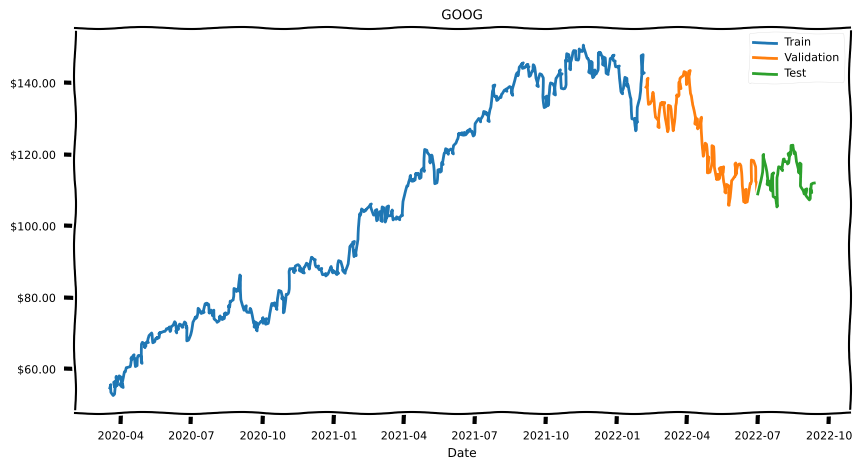

In [22]:
x1 = df.index[-(train_size+val_size+test_size):-(val_size+test_size)]
x2 = df.index[-(val_size+test_size):-test_size]
x3 = df.index[-test_size:]

y1 = scaler_target.inverse_transform(ytrain).flat
y2 = scaler_target.inverse_transform(yval).flat
y3 = scaler_target.inverse_transform(ytest).flat


fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(x1,y1, label="Train")
ax.plot(x2,y2, label="Validation")

ax.plot(x3,y3, label="Test")
ax.set_xlabel("Date")
ax.yaxis.set_major_formatter('${x:1.2f}')

# ax.yaxis.set_tick_params(which='major', labelcolor='green',
#                          labelleft=False, labelright=True)
ax.legend()
ax.set_title("GOOG")
plt.savefig("figures/chart.png")
plt.show()

In [23]:
n_samples, n_steps, n_features = xtrain.shape

# Define Modals

## Model 1 (Stacked-LSTM)





In [24]:
model1 = Sequential()
model1.add(Input((n_steps, n_features), name="Input_layer"))
model1.add(LSTM(50, activation='relu', return_sequences=True, name="LSTM_layer1"))
model1.add(LSTM(50, activation='relu', name="LSTM_layer2"))
model1.add(Dense(1, name="prediction_layer"))
model1.compile(optimizer='adam', loss='mse')

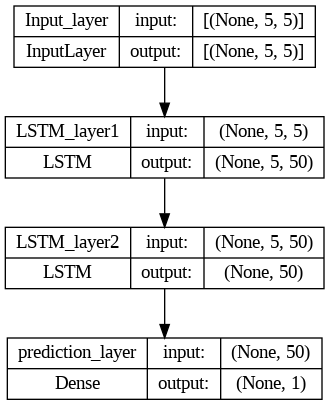

In [25]:
plot_model(model1,to_file = "figures/model/model1.png", show_shapes = True, show_layer_names = True)

## Model 2 (Stacked LSTM,GRU)





In [26]:
model2 = Sequential()
model2.add(Input((n_steps, n_features), name="Input_layer"))
model2.add(LSTM(50, activation='relu', return_sequences=True, name="LSTM_layer"))
model2.add(GRU(50, activation='relu', name="GRU_layer"))
model2.add(Dense(1, name="Prediction_layer"))
model2.compile(optimizer='adam', loss='mse')

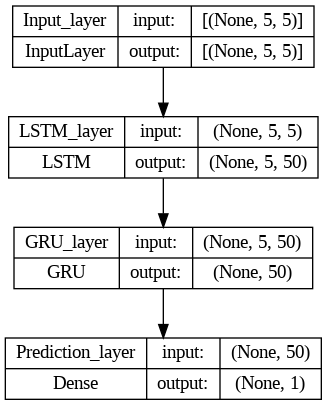

In [27]:
plot_model(model2,to_file = "figures/model/model2.png", show_shapes = True, show_layer_names = True)


## Model 3 (Bidirectional LSTM)


In [28]:
model3 = Sequential()
model3.add(Input((n_steps, n_features), name="Input_layer"))
model3.add(Bidirectional(LSTM(50, activation='relu', name="LSTM_layer"),name="Bidirectional"))
model3.add(Dense(1, name="Prediction_layer"))
model3.compile(optimizer='adam', loss='mse')


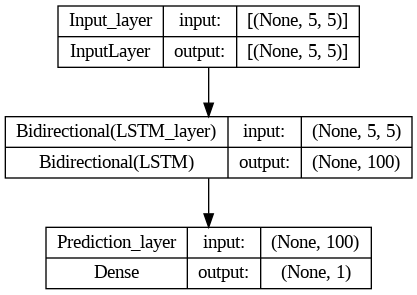

In [29]:
plot_model(model3,to_file = "figures/model/model3.png", show_shapes = True, show_layer_names = True)


## Model4 (Bidirectional GRU)


In [30]:
model4 = Sequential()
model4.add(Input((n_steps, n_features), name="Input_layer"))

model4.add(Bidirectional(GRU(50, activation='relu',name="GRU_layer"), name="Bidirectional"))
model4.add(Dense(1, name="Prediction_layer"))
model4.compile(optimizer='adam', loss='mse')


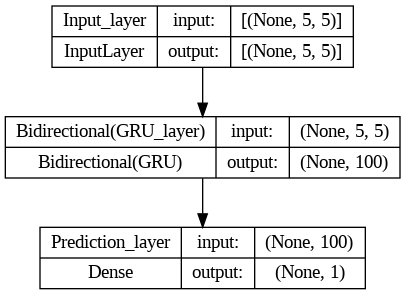

In [31]:
plot_model(model4,to_file = "figures/model/model4.png", show_shapes = True, show_layer_names = True)


## Model5 (CNN-LSTM)

In [32]:
model5 = Sequential()
model5.add(Input((n_steps, n_features), name="Input_layer"))
model5.add(Reshape((-1, n_steps, n_features), name="Reshape_layer"))

model5.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', name="Conv1D_layer"), name="TimeDistributed_1" ))
model5.add(TimeDistributed(MaxPooling1D(pool_size=2, name="MaxPooling1D_layer"), name="TimeDistributed_2"))
model5.add(TimeDistributed(Flatten(name="Flatting_layer"),name="TimeDistributed"))
model5.add(LSTM(50, activation='relu', name="LSTM_layer"))
model5.add(Dense(1, name="Prediction_layer"))
model5.compile(optimizer='adam', loss='mse')

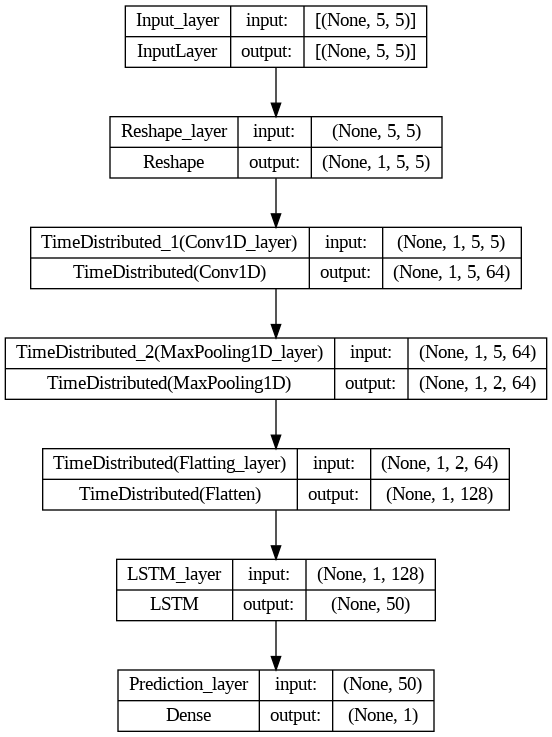

In [33]:
plot_model(model5,to_file = "figures/model/model5.png", show_shapes = True, show_layer_names = True)


## Model6 (ConvLSTM)

In [34]:
model6 = Sequential()
model6.add(Input((n_steps, n_features), name="Input_layer"))
model6.add(Reshape((-1,1, n_steps, n_features), name="Reshape_layer"))

model6.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', name="ConvLSTM_layer"))
model6.add(Flatten(name="Flatting_layer"))
model6.add(Dense(1, name="Prediction_layer"))
model6.compile(optimizer='adam', loss='mse')


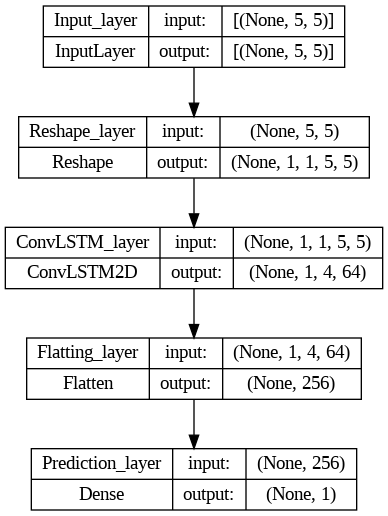

In [35]:
plot_model(model6,to_file = "figures/model/model6.png", show_shapes = True, show_layer_names = True)


## model7 (Multiple Stack models)

In [36]:
model7_1 = Sequential()
model7_2 = Sequential()
model7_3 = Sequential()

n_samples1, n_steps1, n_features1 = x_seq1.shape
n_samples2, n_steps2, n_features2 = x_seq2.shape
n_samples3, n_steps3, n_features3 = x_seq3.shape

model7_1.add(Input((n_steps1, n_features1), name="Input_layer1"))
model7_1.add(LSTM(50, activation='relu', return_sequences=True, name="LSTM_layer1_1"))
model7_1.add(LSTM(50, activation='relu', name="LSTM_layer1_2"))
model7_1.add(Dense(1, name="Prediction_layer1"))

model7_2.add(Input((n_steps2, n_features2), name="Input_layer2"))
model7_2.add(LSTM(50, activation='relu', return_sequences=True, name="LSTM_layer2_1"))
model7_2.add(LSTM(50, activation='relu', name="LSTM_layer2_2"))
model7_2.add(Dense(1, name="Prediction_layer2"))

model7_3.add(Input((n_steps3, n_features3), name="Input_layer3"))
model7_3.add(LSTM(50, activation='relu', return_sequences=True, name="LSTM_layer3_1"))
model7_3.add(LSTM(50, activation='relu', name="LSTM_layer3_2"))
model7_3.add(Dense(1, name="Prediction_layer3"))


combined_7 = Add(name="Add_predition_layer")([model7_1.output, model7_2.output, model7_3.output])
model7 = Model(inputs=[model7_1.input, model7_2.input, model7_3.input], outputs=combined_7)

model7.compile(optimizer='adam', loss='mse')



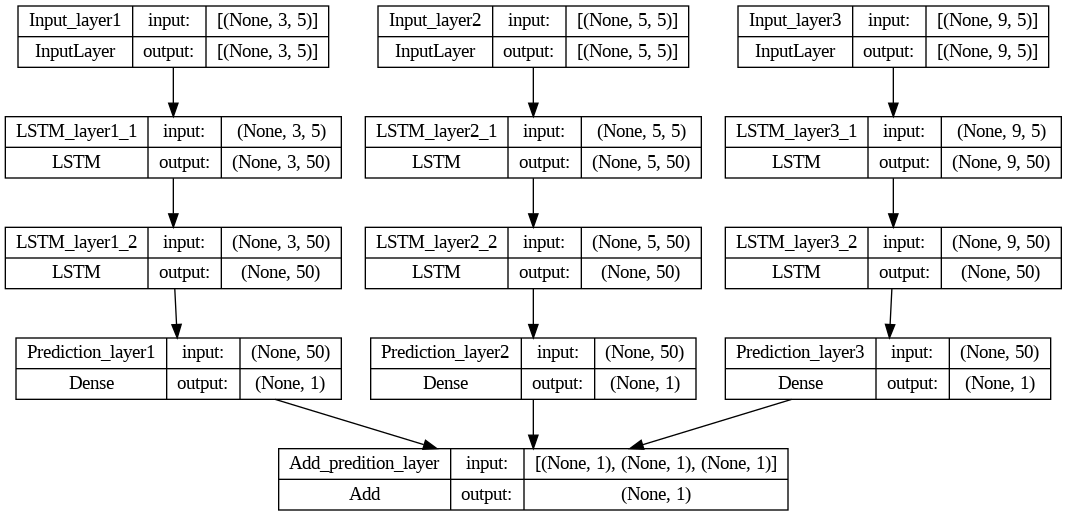

In [37]:
plot_model(model7,to_file = "figures/model/model7.png", show_shapes = True, show_layer_names = True)


## model8 (Multiple ConvLSTM models)

In [38]:
xtrain4 = xtrain1[:,2,:]
xval4 = xval1[:,2,:]
xtest4 = xtest1[:,2,:]

In [39]:
model8_1 = Sequential()
model8_2 = Sequential()
model8_4 = Sequential()
model8_3 = Sequential()

model8_1.add(Input((n_steps1, n_features1), name="Input_layer1"))
model8_1.add(Reshape((-1,1, n_steps1, n_features1), name="Reshape_layer_1"))

model8_1.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu',return_sequences=True, name="ConvLSTM_layer1_1"))
model8_1.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', name="ConvLSTM_layer1_2"))
model8_1.add(Flatten(name="Flatting_layer1"))
model8_1.add(Dense(1, name="Prediction_layer1"))


model8_2.add(Input((n_steps2, n_features2), name="Input_layer2"))
model8_2.add(Reshape((-1,1, n_steps2, n_features2), name="Reshape_layer_2"))

model8_2.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu',return_sequences=True, name="ConvLSTM_layer2_1"))
model8_2.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', name="ConvLSTM_layer2_2"))
model8_2.add(Flatten(name="Flatting_layer2"))
model8_2.add(Dense(1, name="Prediction_layer2"))


model8_3.add(Input((n_steps3, n_features3), name="Input_layer3"))
model8_3.add(Reshape((-1,1, n_steps3, n_features3), name="Reshape_layer_3"))
model8_3.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu',return_sequences=True, name="ConvLSTM_layer3_1"))
model8_3.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', name="ConvLSTM_layer3_2"))
model8_3.add(Flatten(name="Flatting_layer3"))
model8_3.add(Dense(1, name="Prediction_layer3"))

model8_4.add(Input((5,), name="Input_layer4"))
model8_4.add(Dense(128, name="Encode_layer4"))
model8_4.add(Dense(32, name="latent_space_layer"))
model8_4.add(Dense(128, name="Decode_layer4"))
model8_4.add(Dense(1, name="Prediction_layer4"))

combined8 = Add(name="Add_predition_layer")([model8_1.output, model8_2.output, model8_3.output,model8_4.output])
model8 = Model(inputs=[model8_1.input, model8_2.input, model8_3.input,model8_4.input], outputs=combined8)

model8.compile(optimizer='adam', loss='mse')




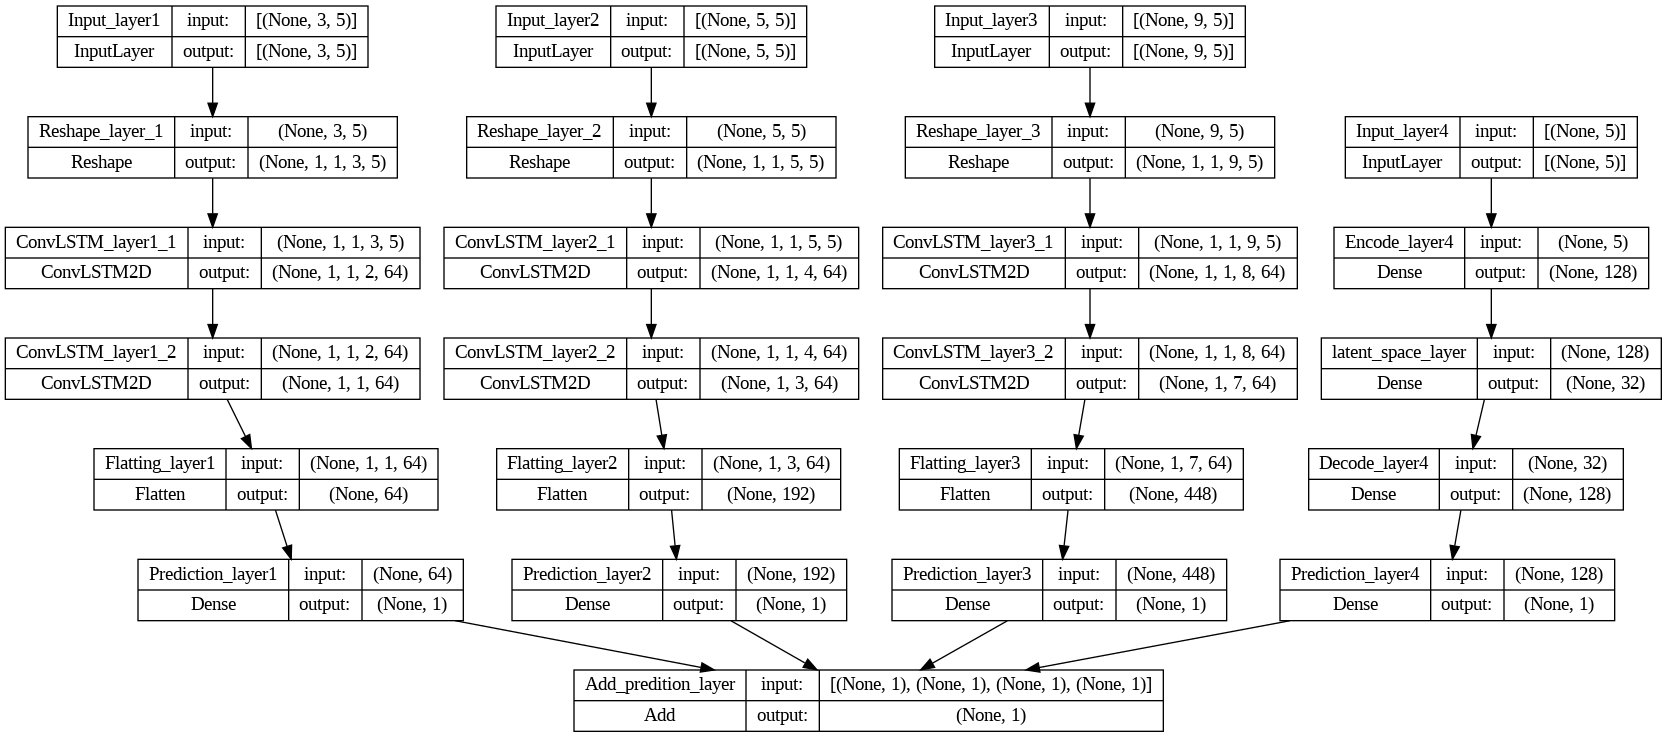

In [40]:
plot_model(model8,to_file = "figures/model/model8.png", show_shapes = True, show_layer_names = True)


# Training model

In [41]:
epochs= 10
batch_size = 8

In [42]:
history_model1 = model1.fit(xtrain, ytrain,batch_size=batch_size,epochs=epochs, validation_data=(xval, yval), shuffle=False)


Epoch 1/10
60/60 [==============================] - 14s 49ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 2/10
60/60 [==============================] - 1s 17ms/step - loss: 0.0127 - val_loss: 0.0026
Epoch 3/10
60/60 [==============================] - 1s 18ms/step - loss: 0.0095 - val_loss: 0.0042
Epoch 4/10
60/60 [==============================] - 1s 12ms/step - loss: 0.0081 - val_loss: 0.0053
Epoch 5/10
60/60 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 6/10
60/60 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 7/10
60/60 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 8/10
60/60 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 9/10
60/60 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 10/10
60/60 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0041


In [43]:
history_model2 = model2.fit(xtrain, ytrain,batch_size=batch_size,epochs=epochs, validation_data=(xval, yval), shuffle=False)


Epoch 1/10
60/60 [==============================] - 4s 22ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 2/10
60/60 [==============================] - 1s 13ms/step - loss: 0.0153 - val_loss: 0.0076
Epoch 3/10
60/60 [==============================] - 1s 13ms/step - loss: 0.0148 - val_loss: 0.0081
Epoch 4/10
60/60 [==============================] - 1s 12ms/step - loss: 0.0090 - val_loss: 0.0046
Epoch 5/10
60/60 [==============================] - 1s 13ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 6/10
60/60 [==============================] - 1s 16ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 7/10
60/60 [==============================] - 1s 20ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 8/10
60/60 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 9/10
60/60 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 10/10
60/60 [==============================] - 1s 17ms/step - loss: 0.0010 - val_loss: 0.0023


In [44]:
history_model3 = model3.fit(xtrain, ytrain,batch_size=batch_size,epochs=epochs, validation_data=(xval, yval), shuffle=False)


Epoch 1/10
60/60 [==============================] - 6s 13ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0020
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/10
60/60 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 6/10
60/60 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 7/10
60/60 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 8/10
60/60 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 9/10
60/60 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 10/10
60/60 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0032


In [45]:
history_model4 = model4.fit(xtrain, ytrain,batch_size=batch_size,epochs=epochs, validation_data=(xval, yval), shuffle=False)


Epoch 1/10
60/60 [==============================] - 4s 13ms/step - loss: 0.0035 - val_loss: 0.0071
Epoch 2/10
60/60 [==============================] - 0s 8ms/step - loss: 0.0132 - val_loss: 0.0060
Epoch 3/10
60/60 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 9.3157e-04 - val_loss: 0.0021
Epoch 6/10
60/60 [==============================] - 0s 8ms/step - loss: 8.8941e-04 - val_loss: 0.0020
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 8.3972e-04 - val_loss: 0.0020
Epoch 8/10
60/60 [==============================] - 0s 8ms/step - loss: 8.0332e-04 - val_loss: 0.0019
Epoch 9/10
60/60 [==============================] - 0s 8ms/step - loss: 7.7070e-04 - val_loss: 0.0019
Epoch 10/10
60/60 [==============================] - 0s 7ms/step - loss: 7.5789e-04 - val_loss: 0

In [46]:
history_model5 = model5.fit(xtrain, ytrain,batch_size=batch_size,epochs=epochs, validation_data=(xval, yval), shuffle=False)


Epoch 1/10
60/60 [==============================] - 3s 14ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0023
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 8/10
60/60 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 9/10
60/60 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 10/10
60/60 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0027


In [47]:
history_model6 = model6.fit(xtrain, ytrain,batch_size=batch_size,epochs=epochs, validation_data=(xval, yval), shuffle=False)

Epoch 1/10
60/60 [==============================] - 3s 10ms/step - loss: 0.0184 - val_loss: 0.0031
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 9.3931e-04 - val_loss: 0.0019
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 8.6788e-04 - val_loss: 0.0019
Epoch 8/10
60/60 [==============================] - 0s 5ms/step - loss: 8.4509e-04 - val_loss: 0.0019
Epoch 9/10
60/60 [==============================] - 0s 5ms/step - loss: 8.3295e-04 - val_loss: 0.0019
Epoch 10/10
60/60 [==============================] - 0s 5ms/step - loss: 8.2400e-04 - val_loss: 0.001

In [48]:
history_model7 = model7.fit([xtrain1,xtrain2,xtrain3], ytrain1, validation_data=([xval1,xval2,xval3],yval1), epochs=epochs, batch_size=batch_size, shuffle=False)


Epoch 1/10
60/60 [==============================] - 20s 58ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 2/10
60/60 [==============================] - 4s 70ms/step - loss: 0.0132 - val_loss: 0.0047
Epoch 3/10
60/60 [==============================] - 5s 86ms/step - loss: 0.0083 - val_loss: 0.0034
Epoch 4/10
60/60 [==============================] - 3s 52ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 5/10
60/60 [==============================] - 3s 56ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 6/10
60/60 [==============================] - 3s 56ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 7/10
60/60 [==============================] - 4s 70ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 8/10
60/60 [==============================] - 2s 35ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 9/10
60/60 [==============================] - 3s 48ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 10/10
60/60 [==============================] - 2s 41ms/step - loss: 0.0011 - val_loss: 0.0023


In [49]:
history_model8 = model8.fit([xtrain1,xtrain2,xtrain3,xtrain4 ],
                            ytrain1,
                            validation_data=([xval1,xval2,xval3,xval4],yval1),
                            epochs=epochs,
                            batch_size=batch_size, shuffle=False)


Epoch 1/10
60/60 [==============================] - 31s 86ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 2/10
60/60 [==============================] - 1s 22ms/step - loss: 0.0022 - val_loss: 9.5152e-04
Epoch 3/10
60/60 [==============================] - 1s 23ms/step - loss: 5.9369e-04 - val_loss: 0.0011
Epoch 4/10
60/60 [==============================] - 1s 20ms/step - loss: 6.7157e-04 - val_loss: 0.0011
Epoch 5/10
60/60 [==============================] - 1s 18ms/step - loss: 6.8100e-04 - val_loss: 0.0011
Epoch 6/10
60/60 [==============================] - 1s 20ms/step - loss: 6.8712e-04 - val_loss: 0.0011
Epoch 7/10
60/60 [==============================] - 1s 22ms/step - loss: 6.9853e-04 - val_loss: 0.0011
Epoch 8/10
60/60 [==============================] - 1s 18ms/step - loss: 6.9911e-04 - val_loss: 0.0010
Epoch 9/10
60/60 [==============================] - 2s 26ms/step - loss: 6.9687e-04 - val_loss: 9.9321e-04
Epoch 10/10
60/60 [==============================] - 2s 35ms/step - loss

## plot Trainig chart

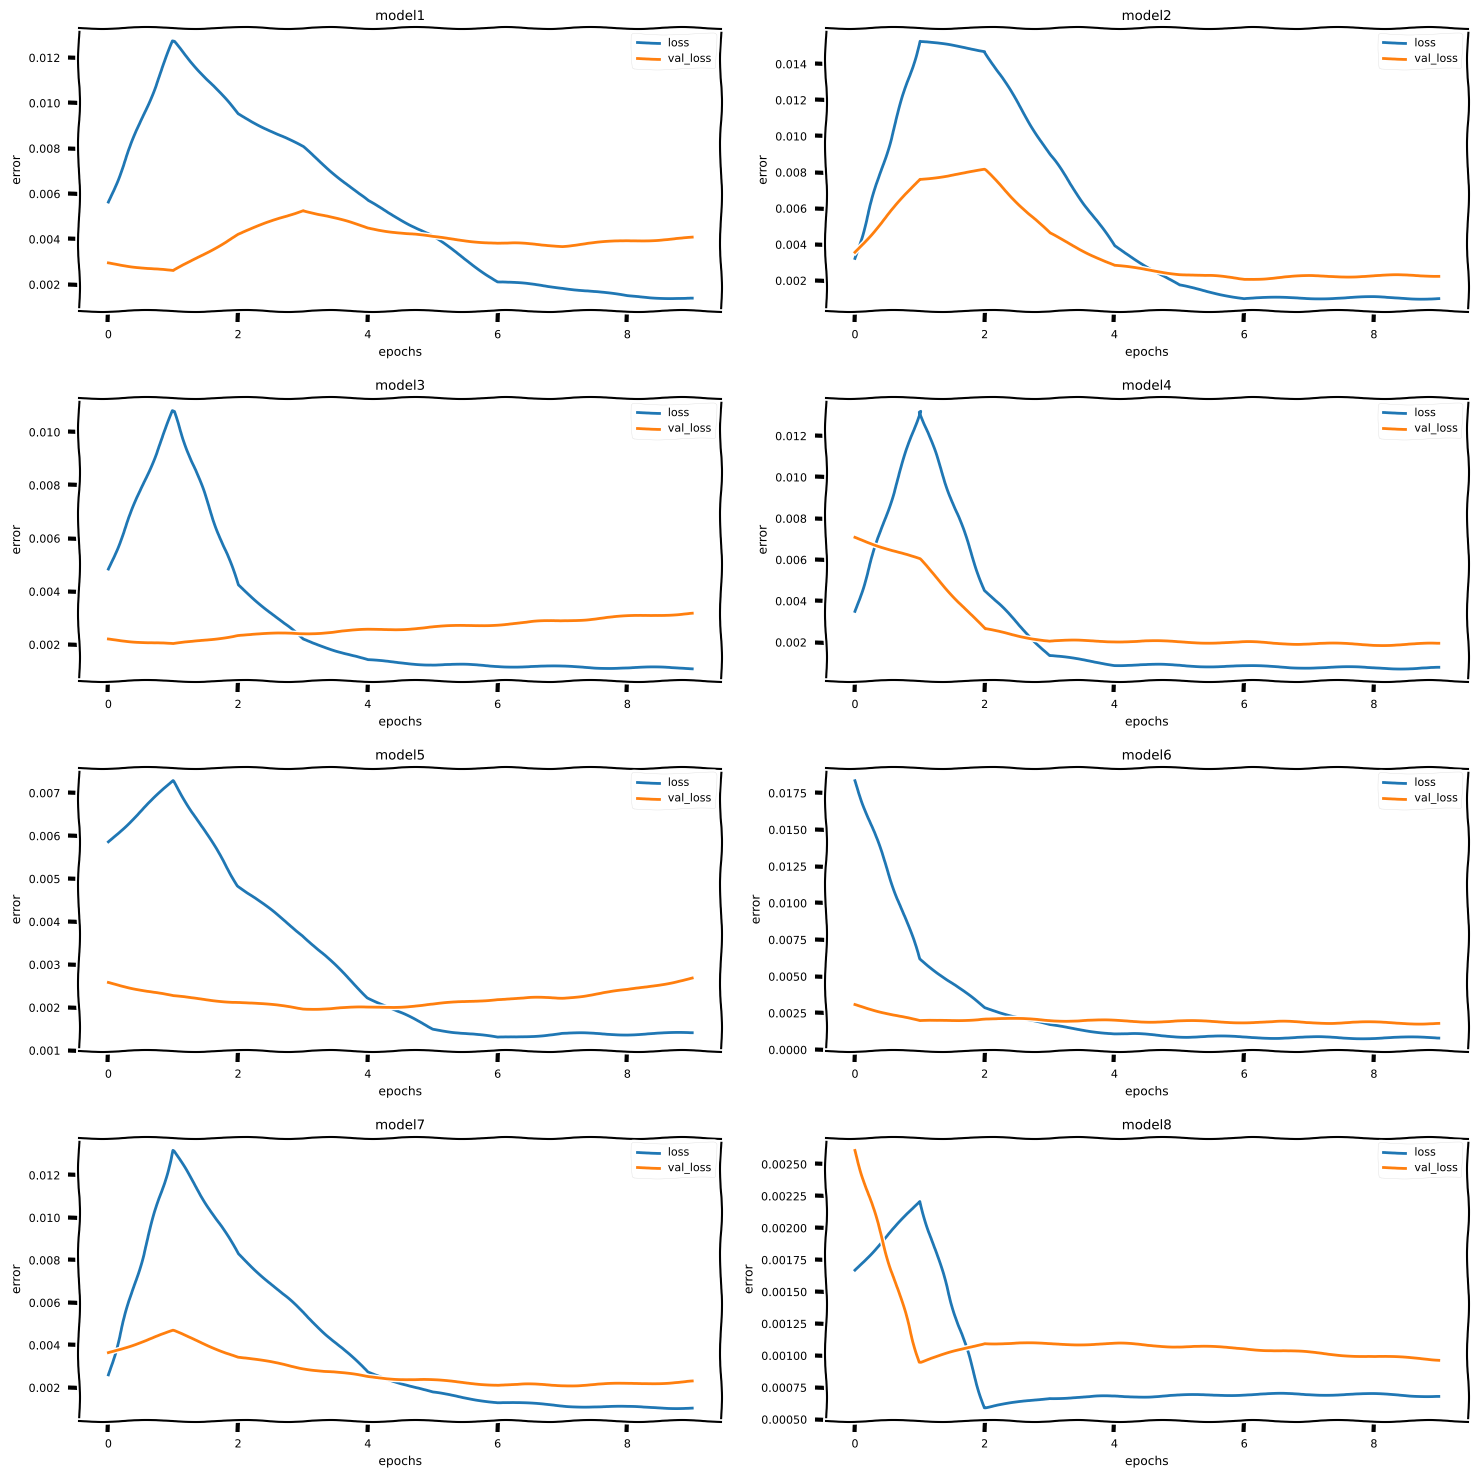

In [50]:
fig, ax = plt.subplots(4,2, figsize=(15,15))
x_= np.arange(epochs)
historys = (history_model1,history_model2,history_model3,history_model4,history_model5,history_model6,history_model7,history_model8)
labels = ("model1","model2","model3","model4","model5","model6","model7","model8")
for history,ax_, label in zip(historys, ax.flat,labels):
    ax_.plot(x_,history.history["loss"], label="loss")
    ax_.plot(x_,history.history["val_loss"],label="val_loss")
    ax_.set_xlabel("epochs")
    ax_.set_ylabel("error")
    ax_.set_title(label)
    ax_.legend()
fig.tight_layout()
plt.savefig(f"figures/history.png")
plt.show()

# Result

In [51]:
models = [model1,model2,model3,model4,model5,model6]
labels = ["model1","model2","model3","model4","model5","model6","model7","model8"]
val_per = []
test_per = []
train_per = []
val_error = []
test_error = []
train_error = []

for model in models:
    pre1 = model.predict(xval, verbose=False)
    pre2 = model.predict(xtest, verbose=False)
    pre3 = model.predict(xtrain, verbose=False)

    pre1 = scaler_target.inverse_transform(pre1)
    pre2 = scaler_target.inverse_transform(pre2)
    pre3 = scaler_target.inverse_transform(pre3)

    t1 = np.sqrt(mse(yval,pre1))
    t2 = np.sqrt(mse(ytest,pre2))
    t3 = np.sqrt(mse(ytrain,pre3))

    val_per.append(pre1)
    test_per.append(pre2)
    train_per.append(pre3)

    val_error.append(t1)
    test_error.append(t2)
    train_error.append(t3)


pre1 = model7.predict([xval1,xval2,xval3], verbose=False)
pre2 = model7.predict([xtest1,xtest2,xtest3], verbose=False)
pre3 = model7.predict([xtrain1,xtrain2,xtrain3], verbose=False)

pre1 = scaler_target.inverse_transform(pre1)
pre2 = scaler_target.inverse_transform(pre2)
pre3 = scaler_target.inverse_transform(pre3)

t1 = np.sqrt(mse(yval,pre1))
t2 = np.sqrt(mse(ytest,pre2))
t3 = np.sqrt(mse(ytrain1,pre3))

val_per.append(pre1)
test_per.append(pre2)
train_per.append(pre3)

val_error.append(t1)
test_error.append(t2)
train_error.append(t3)

pre1 = model8.predict([xval1,xval2,xval3, xval4], verbose=False)
pre2 = model8.predict([xtest1,xtest2,xtest3,xtest4], verbose=False)
pre3 = model8.predict([xtrain1,xtrain2,xtrain3,xtrain4], verbose=False)

pre1 = scaler_target.inverse_transform(pre1)
pre2 = scaler_target.inverse_transform(pre2)
pre3 = scaler_target.inverse_transform(pre3)

t1 = np.sqrt(mse(yval,pre1))
t2 = np.sqrt(mse(ytest,pre2))
t3 = np.sqrt(mse(ytrain1,pre3))

val_per.append(pre1)
test_per.append(pre2)
train_per.append(pre3)

val_error.append(t1)
test_error.append(t2)
train_error.append(t3)




Mean square error:
	model1  Train:110.57$, 	 Validation: 128.62$,	 Test: 118.47$
	model2  Train:109.19$, 	 Validation: 126.60$,	 Test: 115.67$
	model3  Train:110.32$, 	 Validation: 127.97$,	 Test: 117.26$
	model4  Train:107.87$, 	 Validation: 126.08$,	 Test: 115.15$
	model5  Train:109.29$, 	 Validation: 126.38$,	 Test: 116.34$
	model6  Train:107.43$, 	 Validation: 124.64$,	 Test: 112.46$
	model7  Train:109.66$, 	 Validation: 125.96$,	 Test: 116.43$
	model8  Train:108.00$, 	 Validation: 124.87$,	 Test: 113.52$


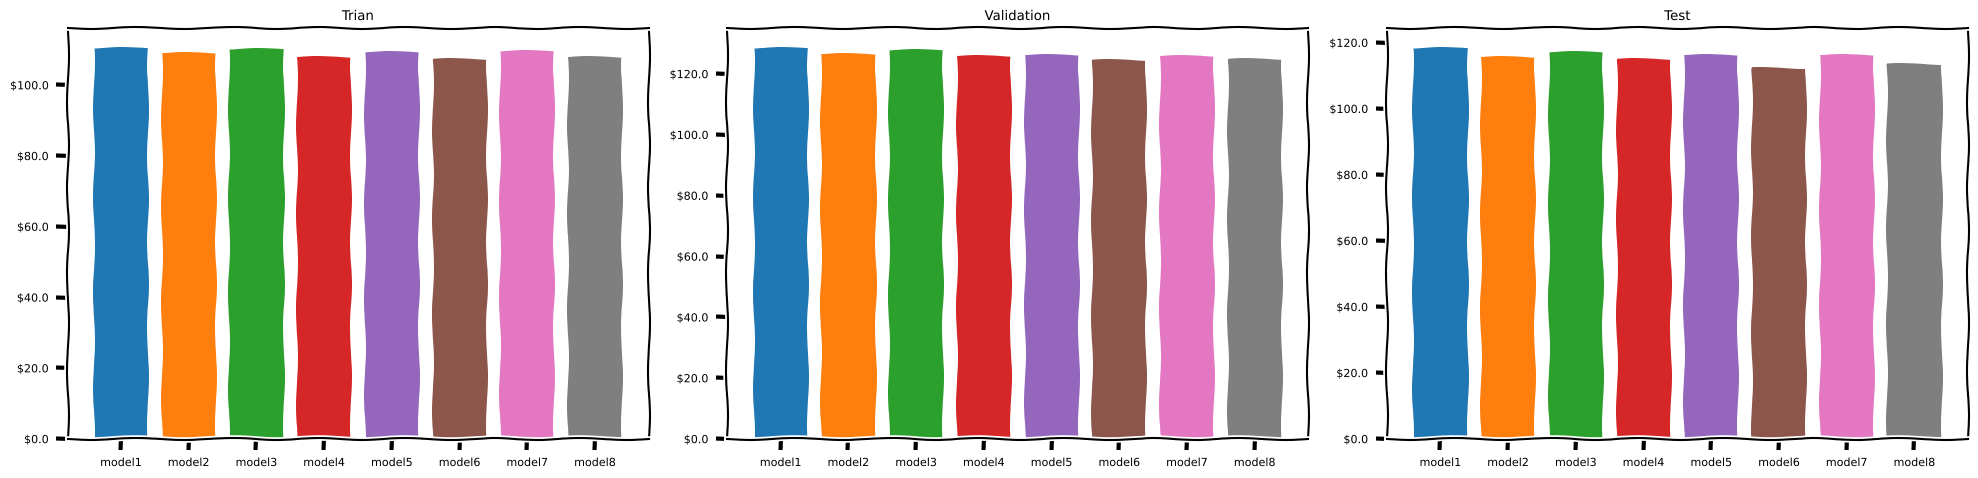

In [52]:
print("Mean square error:")
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,5))

for error1, error2,error3, label in zip(train_error, val_error,test_error, labels):
    print(f"\t{label:7} Train:{error1:.2f}$, \t Validation: {error2:.2f}$,\t Test: {error3:.2f}$")
    ax1.bar(label,error1)
    ax2.bar(label,error2)
    ax3.bar(label,error3)

ax1.set_title("Trian")
ax2.set_title("Validation")
ax3.set_title("Test")
ax1.yaxis.set_major_formatter('${x}')
ax2.yaxis.set_major_formatter('${x}')

# ax1.yaxis.set_tick_params(which='major', labelcolor='green',
#                          labelleft=True, labelright=False)
ax3.yaxis.set_major_formatter('${x}')

# ax2.yaxis.set_tick_params(which='major', labelcolor='green',
#                          labelleft=True, labelright=False)
fig.tight_layout()

plt.savefig("figures/error.png")
plt.show()

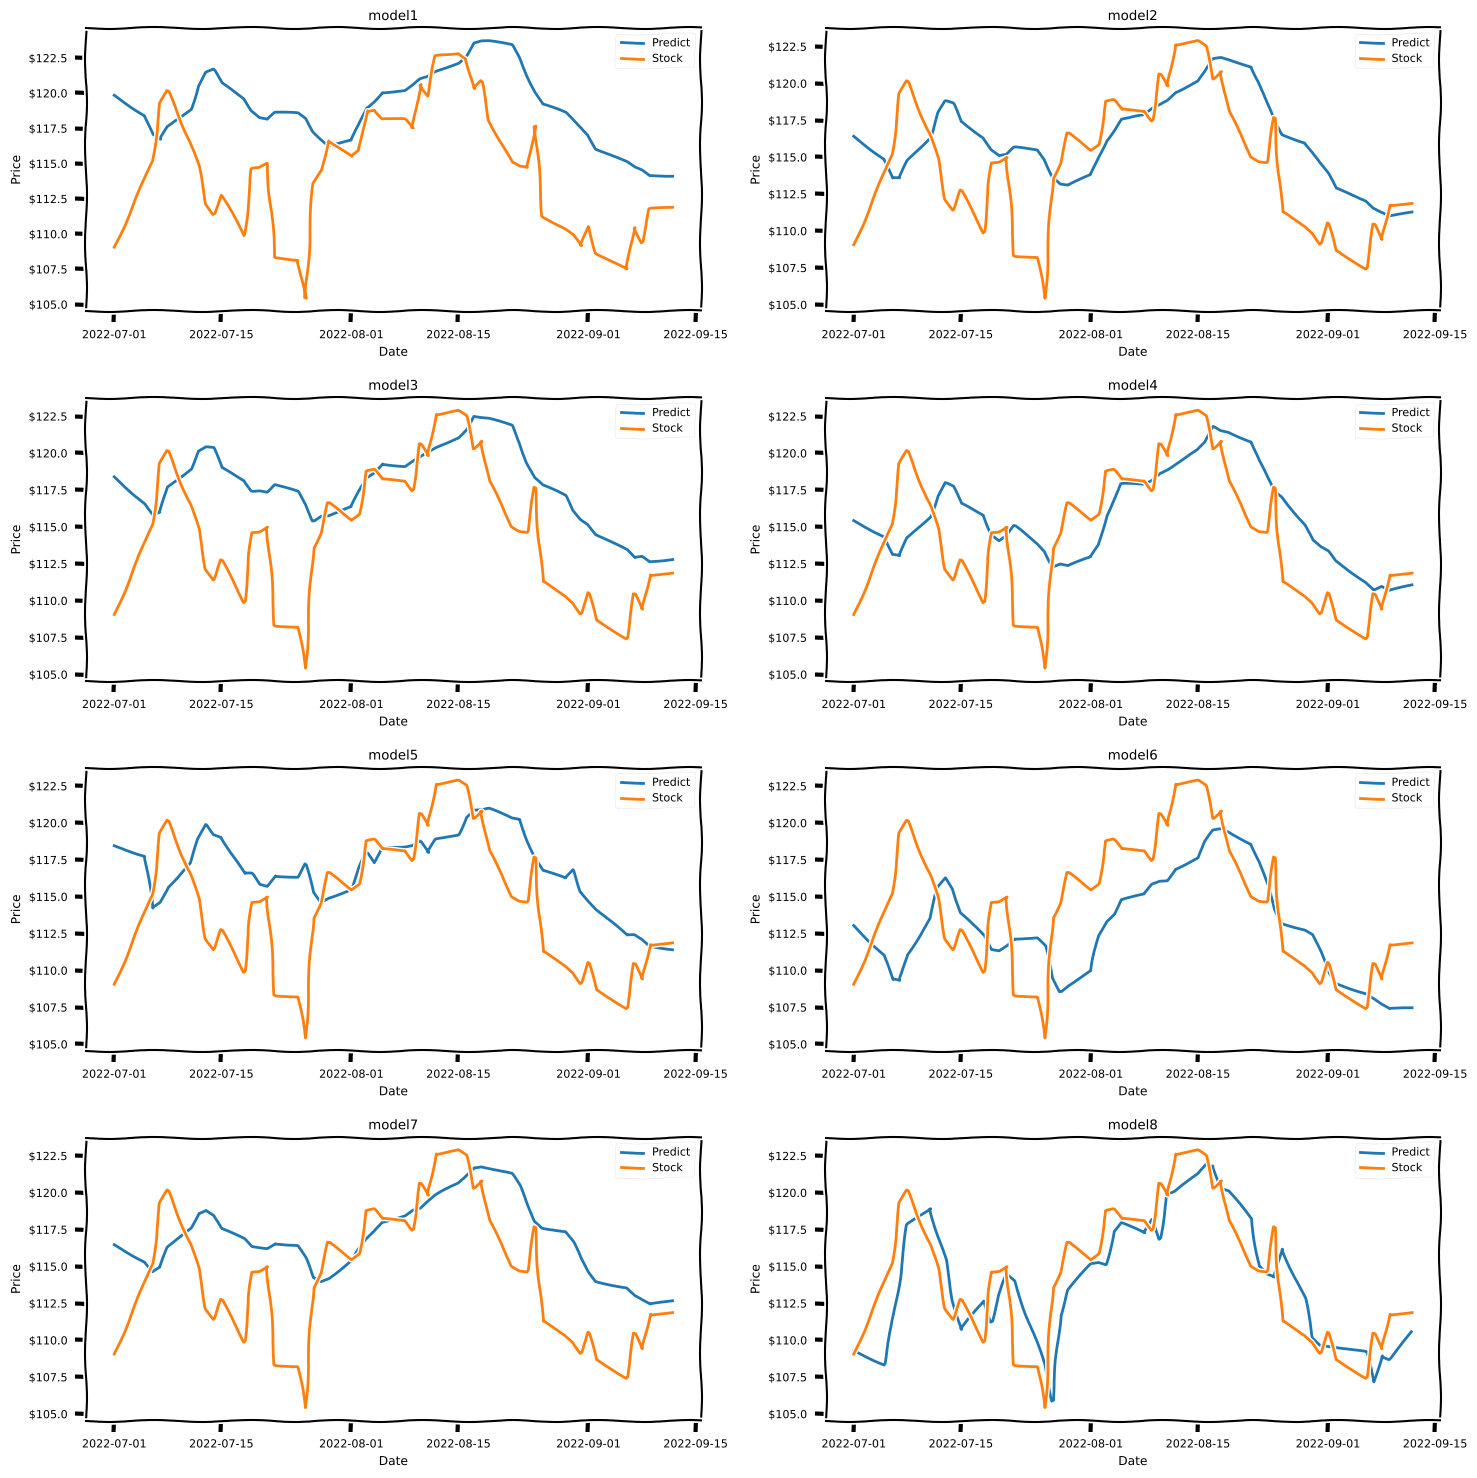

In [53]:
fig, ax = plt.subplots(4,2, figsize=(15,15))

# val_per
# test_per

historys = (history_model1,history_model2,history_model3,history_model4,history_model5,history_model6,history_model7,history_model8)
labels = ("model1","model2","model3","model4","model5","model6","model7","model8")

for pre,ax_, label in zip(test_per, ax.flat,labels):
    ax_.plot(x3,pre, label="Predict")
    ax_.plot(x3,y3,label="Stock")
    ax_.set_xlabel("Date")
    ax_.set_ylabel("Price")
    # ax_.set_xticks(np.arange(epochs))
    ax_.set_title(label)
    ax_.legend()
    ax_.yaxis.set_major_formatter('${x}')

fig.tight_layout()
plt.savefig(f"figures/Result.png")
plt.show()

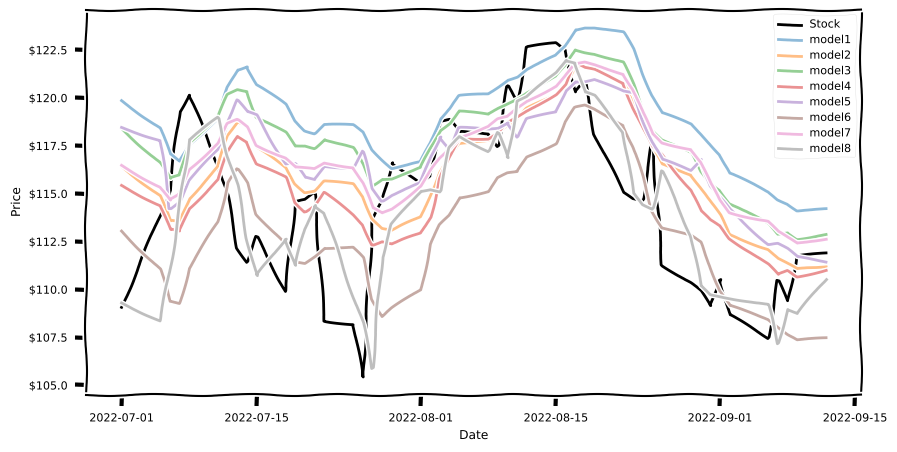

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

# val_per
# test_per

labels = ("model1","model2","model3","model4","model5","model6","model7","model8")

ax.plot(x3,y3,label="Stock", color="Black")

for pre, label in zip(test_per,labels):
    ax.plot(x3,pre, label=label, alpha=0.5)


ax.yaxis.set_major_formatter('${x}')

# ax.yaxis.set_tick_params(which='major', labelcolor='green',
#                          labelleft=True, labelright=False)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
plt.savefig(f"figures/Result2.png")
plt.show()

In [55]:
f = []
name = ["model", "train error","val_error","test_error"]
for i in zip(labels,train_error,val_error,test_error):
    f.append(i)

In [56]:
df__ = pd.DataFrame(f,columns=name)
df__.to_csv("result.csv", index=False)

In [57]:
! zip -r model.zip figures/* *.csv

  adding: figures/chart/ (stored 0%)
  adding: figures/chart.png (deflated 6%)
  adding: figures/error.png (deflated 12%)
  adding: figures/history.png (deflated 7%)
  adding: figures/model/ (stored 0%)
  adding: figures/model/model6.png (deflated 13%)
  adding: figures/model/model7.png (deflated 16%)
  adding: figures/model/model4.png (deflated 12%)
  adding: figures/model/model5.png (deflated 14%)
  adding: figures/model/model3.png (deflated 12%)
  adding: figures/model/model2.png (deflated 13%)
  adding: figures/model/model8.png (deflated 14%)
  adding: figures/model/model1.png (deflated 12%)
  adding: figures/result/ (stored 0%)
  adding: figures/Result2.png (deflated 3%)
  adding: figures/Result.png (deflated 5%)
  adding: result.csv (deflated 46%)


In [58]:
! cp model.zip /content/drive/MyDrive